In [1]:
import torch

In [14]:
class BernoulliVariationalAutoencoder(torch.nn.Module):
    def __init__(self, in_features=167, hidden_features=32, latent_features=2):
        super(BernoulliVariationalAutoencoder, self).__init__()
        self._f_xz_mu = torch.nn.Sequential(
            torch.nn.Linear(in_features, hidden_features),
            torch.nn.ELU(),
            torch.nn.Linear(hidden_features, latent_features,)
        )
        
        self._f_xz_log_sigma = torch.nn.Sequential(
            torch.nn.Linear(in_features, hidden_features),
            torch.nn.ELU(),
            torch.nn.Linear(hidden_features, latent_features,)
        )
        
        self._f_zx = torch.nn.Sequential(
            torch.nn.Linear(latent_features, hidden_features),
            torch.nn.ELU(),
            torch.nn.Linear(hidden_features, in_features),
        )
        
    def f_xz(self, x):
        z_mu, z_log_sigma = self._f_xz_mu(x), self._f_xz_log_sigma(x)
        return torch.distributions.normal.Normal(
            z_mu,
            z_log_sigma.exp()
        )
        
    
    def f_zx(self, z):
        return self._f_zx(z)
        
    def get_loss(self, x):
        z_distribution = self.f_xz(x)
        z = z_distribution.rsample()
        x_new = self.f_zx(z)
        
        latent_distribution = torch.distributions.normal.Normal(
            torch.zeros_like(z),
            torch.ones_like(z),
        )
        
        target_distribution = torch.distributions.bernoulli.Bernoulli(
            probs=torch.sigmoid(x_new),
        )
        
        return z_distribution.log_prob(z).sum() - latent_distribution.log_prob(z).sum() - target_distribution.log_prob(x).sum()

In [15]:
vae = BernoulliVariationalAutoencoder()

In [16]:
import pandas as pd
df = pd.read_csv("/Users/wangy1/Documents/GitHub/pinot/pinot/data/moonshot_with_date.csv")
moonshot_smiles = df["SMILES"]
df_series = pd.read_csv("activity_data.csv")
df = df.merge(df_series, how="left")
from rdkit import Chem
mols = [Chem.MolFromSmiles(smiles) for smiles in moonshot_smiles]
from rdkit.Chem import MACCSkeys
import numpy as np
fps = np.array([MACCSkeys.GenMACCSKeys(x) for x in mols])
x = torch.tensor(fps, dtype=torch.float32)

In [17]:
vae.get_loss(x)

tensor(83939.4922, grad_fn=<SubBackward0>)

In [18]:
optimizer = torch.optim.Adam(vae.parameters(), 1e-5)

for _ in range(10000):
    optimizer.zero_grad()
    loss = vae.get_loss(x)
    loss.backward()
    optimizer.step()
    

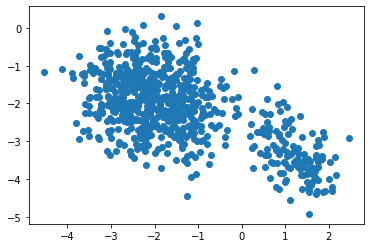

In [19]:
from matplotlib import pyplot as plt
z = vae.f_xz(x).rsample().detach().numpy()
plt.scatter(
    z[:, 0],
    z[:, 1]
)